<a href="https://colab.research.google.com/github/muhammed-bayat/makine-ogrenmesi/blob/main/Makine_Ogrenmesi__Son_Sunum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satranç Kazanan Tahmini

##### İbrahim ŞENGÜN - Muhammed BAYAT

## Problemin Türü
Etiketlerimiz belli ve kategorik olduğu için Sınıflandırma Problemi.

Açılış kodları --> https://www.365chess.com/eco.php

## Veriseti
* **id**: Oyun numarası, nümerik
* **rated**: Değerlendime, kategorik
* **created_at**: Başlangıç zamanı, nümerik
* **last_move_at**: Bitiş zamanı, nümerik
* **turns**: Hamle sayısı, nümerik
* **victory_status**: Kazanan nasıl kazandı, kategorik
* **winner**: Kazanan renk, kategorik
* **increment_code**: Oyunun zaman türü, nümerik
* **white_id**: Beyaz taşlarda ki oyuncunun numarası, nümerik
* **black_id**: Siyah taşlarda ki oyuncunun numarası, nümerik
* **white_rating**: Beyaz taşlarda ki oyuncunun puanı, nümerik
* **black_rating**: Siyah taşlarda ki oyuncunun puanı, nümerik
* **moves**: Hamleler, nümerik
* **opening_eco**: Açılışın kodu, kategorik
* **opening_name**: Açılışın ismi, kategorik
* **opening_ply**: Açılış fazı kaç hamlede tamamlandı, nümerik

## Karışıklık Matrisi

**TP:** Kazanacak kişiye kazandı demek.

**TN:** Kaybedecek kişiye kaybetti demek.

**FP:** Kaybedecek kişiye kazandı demek.

**FN:** Kazanacak kişiye kaybetti demek.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.simplefilter("ignore")

df = pd.read_csv('/content/drive/MyDrive/Colab/ChessGameDataset/games.csv')
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [7]:
df.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

(array([10001.,     0.,     0.,     0.,     0.,  9107.,     0.,     0.,
            0.,   950.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

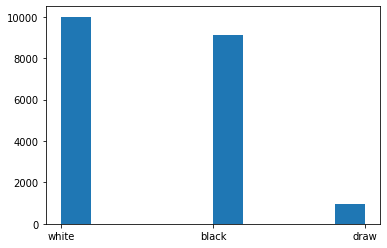

In [8]:
plt.hist(df['winner'])

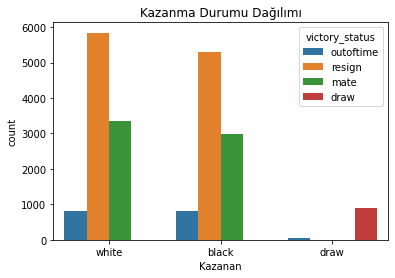

In [9]:
ax = sns.countplot( x = 'winner', hue = 'victory_status', data = df)
ax_attr = ax.set(xlabel = 'Kazanan', title = 'Kazanma Durumu Dağılımı')

* **outoftime:** Rakibin süresi dolması sonucu kazanmak.
* **resign:** Rakibin oyunu terk etmesi sonucu kazanmak.
* **mate:** Rakibi mat ederek kazanmak.
* **draw:** Berabere.

Oyunların büyük çoğunluğu bir tarafın oyunu terk etmesi ile sonuçlanıyor. Hemen arkasında ise mat sonucunda kazanmak geliyor. Beraberlik ise daha nadir gerçekleşen bir olay.

**Dipnot:** draw' durumunda 'outoftime' olma ihtimali düşüktür. Bu ihtimalin gerçekleşmesi için bir oyuncu belirlenen süre içinde belirlenen hamle sayısını tamamlamazsa, oyun oyuncu tarafından kaybedilir. Ancak oyun eğer pozisyon rakip oyuncunun şahını olası herhangi bir yasal hamle dizisi ile mat edemeyecek şekilde ise berabere biter.

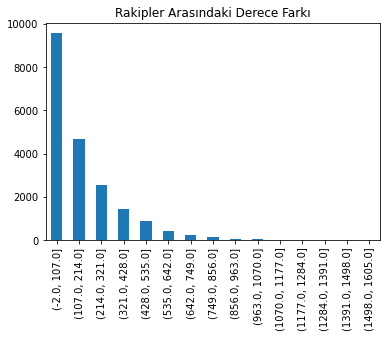

In [10]:
df["rating_diff"] = abs(df['white_rating'] - df['black_rating'])

ax = pd.cut(df["rating_diff"], 15, precision = 0).value_counts().sort_index().plot.bar()
ax_attr = ax.set(title = "Rakipler Arasındaki Derece Farkı")

In [11]:
print("Ortalama Derece Farkı:" ,round(df['rating_diff'].mean(), 3))
print("En Yüksek Derece Farkı:" ,df['rating_diff'].max())
print("En Düşük Derece Farkı:" ,df['rating_diff'].min())

Ortalama Derece Farkı: 173.091
En Yüksek Derece Farkı: 1605
En Düşük Derece Farkı: 0


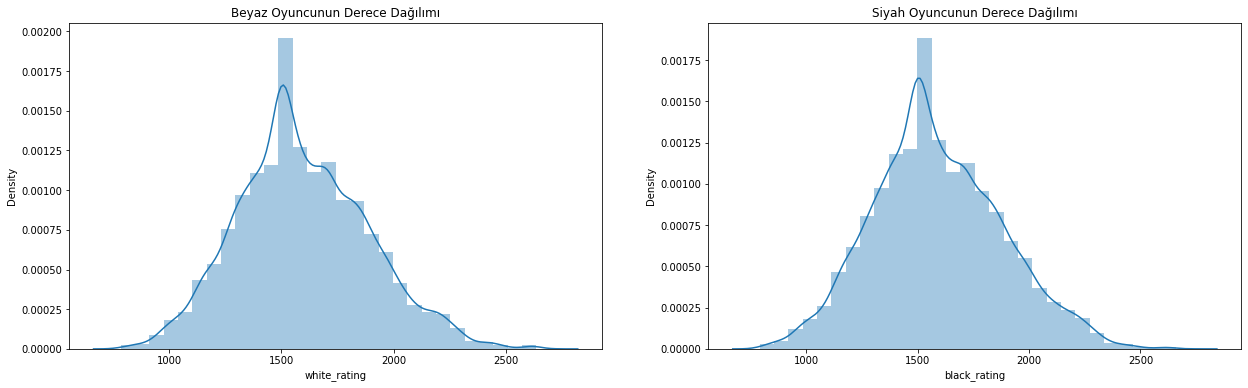

In [12]:
a4_dims = (21, 6)
fig, ax = plt.subplots(1,2,figsize=a4_dims)
sns.distplot(df['white_rating'], bins = 30, ax = ax[0])

sns.distplot(df['black_rating'], bins = 30, ax = ax[1])

ax_attr = ax[0].set(title = "Beyaz Oyuncunun Derece Dağılımı")
ax_attr = ax[1].set(title = "Siyah Oyuncunun Derece Dağılımı")

In [13]:
print('Beyaz oyuncunun ortalama derecesi:',df['white_rating'].mean())
print('Siyah oyuncunun ortalama derecesi:',df['black_rating'].mean())

Beyaz oyuncunun ortalama derecesi: 1596.6318675840064
Siyah oyuncunun ortalama derecesi: 1588.8319872370128


## Veri İşleme
*id*, *white_id*, *black_id* önemsiz veriler.

*created_at* ve *last_move_at* verilerinde de bir dengesizlik var. *created_at* oyunun başlama zamanı, *last_move_at* oyunun bitiş zamanını veriyor. Mantık olarak *last_move_at* - *created_at* farkı bize oyunun ne kadar sürdüğünü vermesi gerekir. Ancak birçok oyunda bu fark *0* oluyor. Bundan dolayı bu veriler de önemsiz verileri arasına giriyor.

In [14]:
duration = df[df['last_move_at']-df['created_at'] == 0].shape[0]
print("Oyun süresi 0 olan oyun sayısı:", duration, "ki bu da yaklaşık olarak tüm oyunların yüzde", round(duration/df.shape[0],2)*100, "denk geliyor")

Oyun süresi 0 olan oyun sayısı: 8548 ki bu da yaklaşık olarak tüm oyunların yüzde 43.0 denk geliyor


Bu yüzden *id*, *white_id*, *black_id*, *created_at* ve *last_move_at* verilerini çıkarıyoruz

In [15]:
#Kullanacağımız veriler
X = df.filter(items=['increment_code', 'opening_eco', 'opening_name', 'rated', 'victory_status', 'turns', 'white_rating', 'black_rating', 'opening_ply', 'rating_diff'])
y = df.filter(items=['winner'])

In [16]:
X

,increment_code,opening_eco,opening_name,rated,victory_status,turns,white_rating,black_rating,opening_ply,rating_diff
0,15+2,D10,Slav Defense: Exchange Variation,False,outoftime,13,1500,1191,5,309
1,5+10,B00,Nimzowitsch Defense: Kennedy Variation,True,resign,16,1322,1261,4,61
2,5+10,C20,King's Pawn Game: Leonardis Variation,True,mate,61,1496,1500,3,4
3,20+0,D02,Queen's Pawn Game: Zukertort Variation,True,mate,61,1439,1454,3,15
4,30+3,C41,Philidor Defense,True,mate,95,1523,1469,5,54
...,...,...,...,...,...,...,...,...,...,...
20053,10+10,A80,Dutch Defense,True,resign,24,1691,1220,2,471
20054,10+0,A41,Queen's Pawn,True,mate,82,1233,1196,2,37
20055,10+0,D00,Queen's Pawn Game: Mason Attack,True,mate,35,1219,1286,3,67
20056,10+0,B07,Pirc Defense,True,resign,109,1360,1227,4,133


In [17]:
#String verileri nümerik formata dönüştürüyoruz
label_encoder = preprocessing.LabelEncoder()  
X = X.apply(label_encoder.fit_transform)

X

,increment_code,opening_eco,opening_name,rated,victory_status,turns,white_rating,black_rating,opening_ply,rating_diff
0,110,248,1387,0,2,12,616,318,4,309
1,298,71,750,1,3,15,438,388,3,61
2,298,171,650,1,1,60,612,627,2,4
3,187,241,992,1,1,60,555,581,2,15
4,247,192,783,1,1,94,639,596,4,54
...,...,...,...,...,...,...,...,...,...,...
20053,21,61,191,1,3,23,807,347,1,471
20054,19,37,960,1,1,81,349,323,1,37
20055,19,239,977,1,1,34,335,413,2,67
20056,19,78,806,1,3,108,476,354,3,133


In [18]:
#Nümerik verilerimize 0-1 arasında değerler atıyoruz
X = preprocessing.normalize(X)

In [19]:
X

array([[0.06856813, 0.15458997, 0.86458183, ..., 0.19822424, 0.00249339,
        0.19261412],
       [0.29759881, 0.07090441, 0.74899029, ..., 0.38747764, 0.00299596,
        0.06091788],
       [0.26018115, 0.14929858, 0.56750922, ..., 0.54742813, 0.00174618,
        0.00349236],
       ...,
       [0.01666118, 0.20958011, 0.85673544, ..., 0.36216145, 0.00175381,
        0.05875258],
       [0.01865486, 0.07658311, 0.79135879, ..., 0.3475695 , 0.0029455 ,
        0.13058402],
       [0.01623802, 0.20425717, 0.83497595, ..., 0.39825874, 0.00170926,
        0.08888178]])

In [20]:
#train ve test verilerini ayırıyoruz
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

In [21]:
#Kullanacağımız yöntemler
names = ["Nearest_Neighbors", "Linear_SVM", "Decision_Tree", "Random_Forest"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(),
    RandomForestClassifier()]

In [22]:
#
f1_scores = []
acc_scores = []
for name, clf in zip(names, classifiers):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    f1s = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    f1_scores.append(f1s)
    acc_scores.append(acc)

In [23]:
results = pd.DataFrame()
results['name'] = names
results['f1_score'] = f1_scores
results['accuracy_score'] = acc_scores

In [24]:
cm = sns.light_palette("green", as_cmap=True)
s = results.style.background_gradient(cmap=cm)
s

,name,f1_score,accuracy_score
0,Nearest_Neighbors,0.419549,0.592223
1,Linear_SVM,0.368714,0.589731
2,Decision_Tree,0.718008,0.622134
3,Random_Forest,0.766143,0.678714


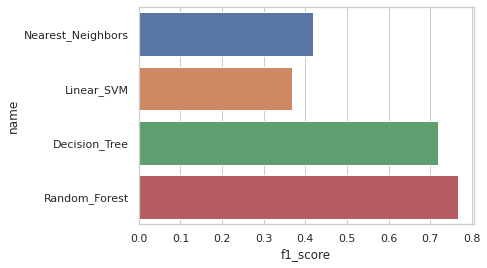

In [25]:
sns.set(style="whitegrid")
ax1 = sns.barplot(y="name", x="f1_score", data=results)

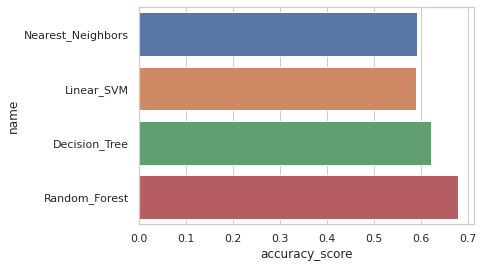

In [26]:
sns.set(style="whitegrid")
ax1 = sns.barplot(y="name", x="accuracy_score", data=results)

Bu grafikler sonucunda, kazanan tahmini probleminde seçmemiz gereken yöntem *Random_Forest_Classifier*.

              precision    recall  f1-score   support

       black       0.59      0.57      0.58      1821
        draw       0.93      0.95      0.94       186
       white       0.62      0.64      0.63      2005

    accuracy                           0.62      4012
   macro avg       0.71      0.72      0.72      4012
weighted avg       0.62      0.62      0.62      4012



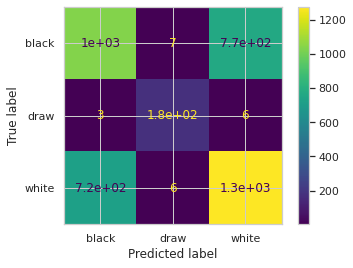

In [27]:
tree_clf = DecisionTreeClassifier().fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=tree_clf.predict(x_test)))
plot_confusion_matrix(tree_clf, x_test, y_test)

## Kaynaklar
- https://www.kaggle.com/nelver/lichess-predicting-a-winner/comments
- https://www.datasciencearth.com/python-uygulamasi-ile-karar-agaclari/
- https://github.com/dataprofessor/code/blob/master/python/comparing-classifiers.ipynb
- https://www.kaggle.com/atdata/lichess-chess-games-dataset-eda-using-python
- https://www.kaggle.com/jeffd23/10-classifier-showdown-in-scikit-learn